In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from time import strptime
import os 
import patsy 
from shapely.wkt import loads
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests 

In [2]:
cin_pkl = open('cinems_bg_pkl_030320', 'rb')
cin = pickle.load(cin_pkl)

temp_pkl = open('tempems_bg_pkl_030320', 'rb')
temp = pickle.load(temp_pkl)



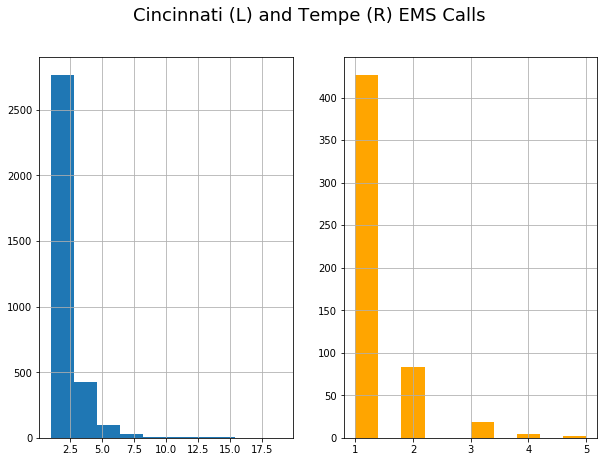

In [3]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Cincinnati (L) and Tempe (R) EMS Calls', size=18)
cin.ems_calls.hist(figsize=(10,7), ax=ax1)
temp.ems_calls.hist(figsize=(10,7), ax=ax2, color='orange')

In [4]:
#variable cleaning in cin
cin['log_pop'] = np.log(cin.Tot_Population_ACS_13_17)
cin.Med_HHD_Inc_BG_ACS_13_17 = cin.Med_HHD_Inc_BG_ACS_13_17/100000
cin.Med_House_Value_BG_ACS_13_17 = cin.Med_House_Value_BG_ACS_13_17/1000000
scl = ['pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17','pct_Pop_25_44_ACS_13_17','pct_Pop_45_64_ACS_13_17',
       'pct_Pop_65plus_ACS_13_17','pct_Hispanic_ACS_13_17','pct_NH_White_alone_CEN_2010', 
       'pct_NH_Blk_alone_ACS_13_17','pct_NH_Asian_alone_ACS_13_17',
       'pct_Prs_Blw_Pov_Lev_ACS_13_17','pct_College_ACS_13_17']

for i in range(len(scl)):
    cin[scl[i]] = cin[scl[i]]/100
    

In [5]:
#variable cleaning in tempe
temp['log_pop'] = np.log(cin.Tot_Population_ACS_13_17)
temp.Med_HHD_Inc_BG_ACS_13_17 = temp.Med_HHD_Inc_BG_ACS_13_17/100000
temp.Med_House_Value_BG_ACS_13_17 = temp.Med_House_Value_BG_ACS_13_17/1000000
scl = ['pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17','pct_Pop_25_44_ACS_13_17','pct_Pop_45_64_ACS_13_17',
       'pct_Pop_65plus_ACS_13_17','pct_Hispanic_ACS_13_17','pct_NH_White_alone_CEN_2010', 
       'pct_NH_Blk_alone_ACS_13_17','pct_NH_Asian_alone_ACS_13_17',
       'pct_Prs_Blw_Pov_Lev_ACS_13_17','pct_College_ACS_13_17']

for i in range(len(scl)):
    temp[scl[i]] = temp[scl[i]]/100

### Cincinnati Sub Anaysis 

Going to split data into above and below number of calls to see if co-factors change in areas where there is a lot of drug use versus a little 

In [6]:
np.median(cin.ems_calls)

1.0

In [7]:
cin['ems_flag'] = 0 
for i in range(len(cin)):
    if cin['ems_calls'][i] >np.median(cin['ems_calls']):
        cin['ems_flag'][i] =1

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [8]:
cin.ems_flag.value_counts()

0    2058
1    1281
Name: ems_flag, dtype: int64

In [9]:
### partion into high and low classes 
cin_lo = cin[cin['ems_flag'] ==0]
cin_hi = cin[cin['ems_flag']==1]

In [10]:
cin_lo.shape

(2058, 21)

In [11]:
cin_lo.ems_calls.value_counts()

1    2058
Name: ems_calls, dtype: int64

In [12]:
cin_hi.shape

(1281, 21)

In [13]:
cin_hi.ems_calls.value_counts()

2     705
3     282
4     142
5      60
6      35
8      15
7      14
10      8
9       8
12      4
14      3
13      3
19      1
11      1
Name: ems_calls, dtype: int64

#### OLS in Cincinnati in low use year-month tracts

In [14]:
cin_lo.dropna(inplace=True)
X, y = cin_lo, cin_lo.ems_calls
X.drop(columns=['geometry','ems_calls','year_month', 'Tot_Population_ACS_13_17', 'GIDBG', 'GEOID', 'ems_flag'], inplace=True)

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1db2d5f8>,
      dtype=object)

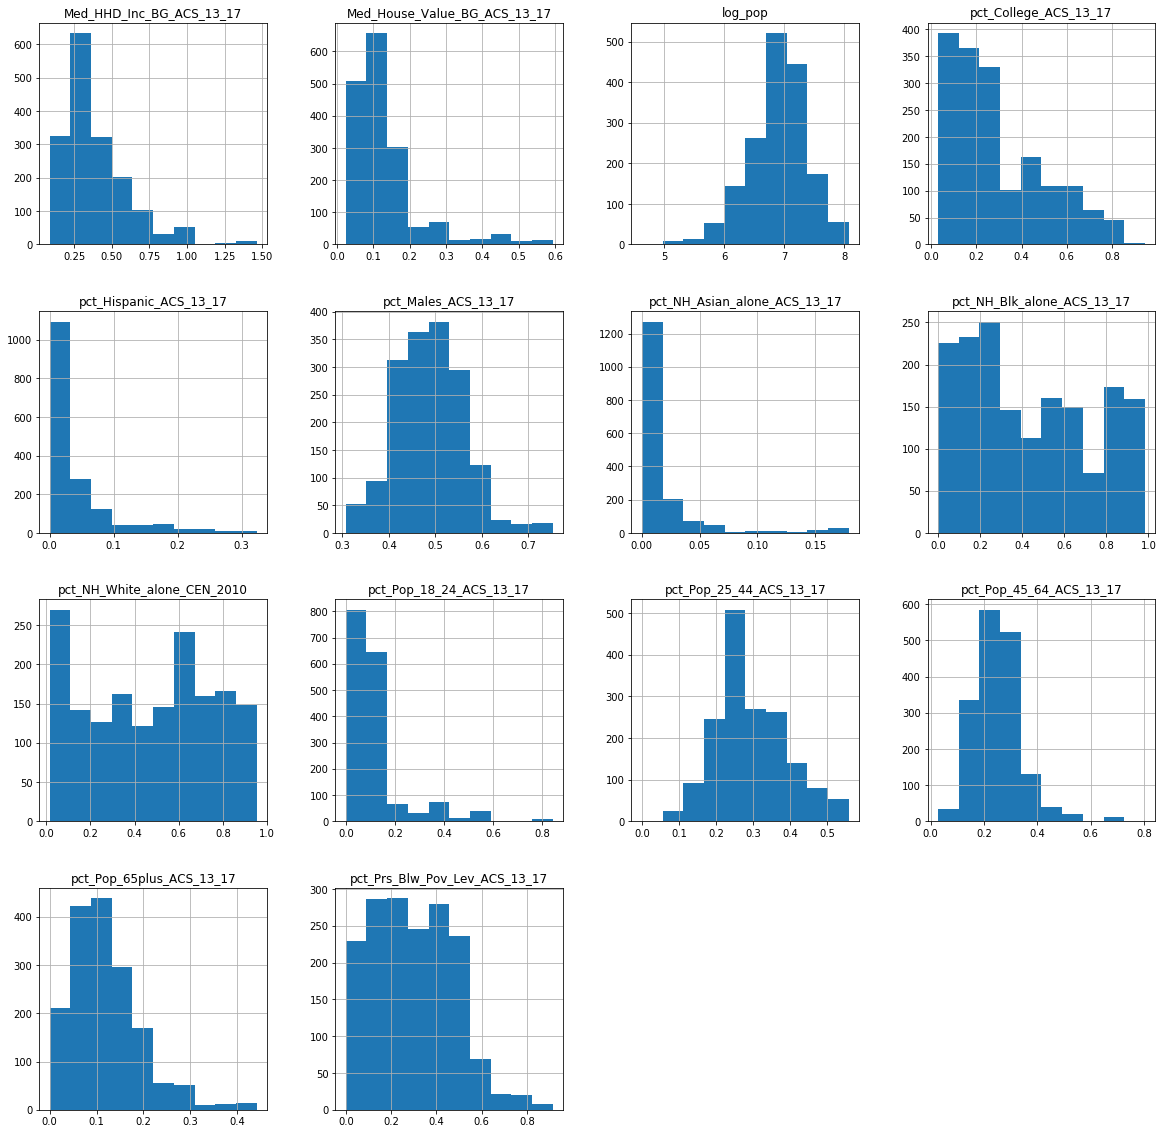

In [15]:
#get descriptive stats of predictors
X.hist(figsize=(20,20))

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
res = sm.OLS(y_train, X_train).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              ems_calls   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 6.175e+04
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        21:48:06   Log-Likelihood:                 2446.5
No. Observations:                1344   AIC:                            -4865.
Df Residuals:                    1330   BIC:                            -4792.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
pct_Males_ACS_

In [18]:
#Check Predictions
pred = res.predict(X_test)

In [19]:
y_test.index = y_test.index.sort_values()
pred.index = pred.index.sort_values()

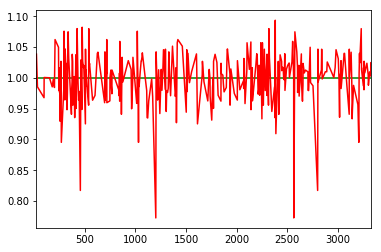

In [20]:
fig, ax = plt.subplots()
y_test.plot(style='g-', ax=ax)
pred.plot(style='r-', ax=ax)

#### OLS in Cincinnati in high use year-month tracts

In [23]:
cin_hi.dropna(inplace=True)
X, y = cin_hi, cin_hi.ems_calls
X.drop(columns=['geometry','ems_calls','year_month', 'Tot_Population_ACS_13_17', 'GIDBG', 'GEOID', 'ems_flag'], inplace=True)

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x107bc3e80>,
      dtype=object)

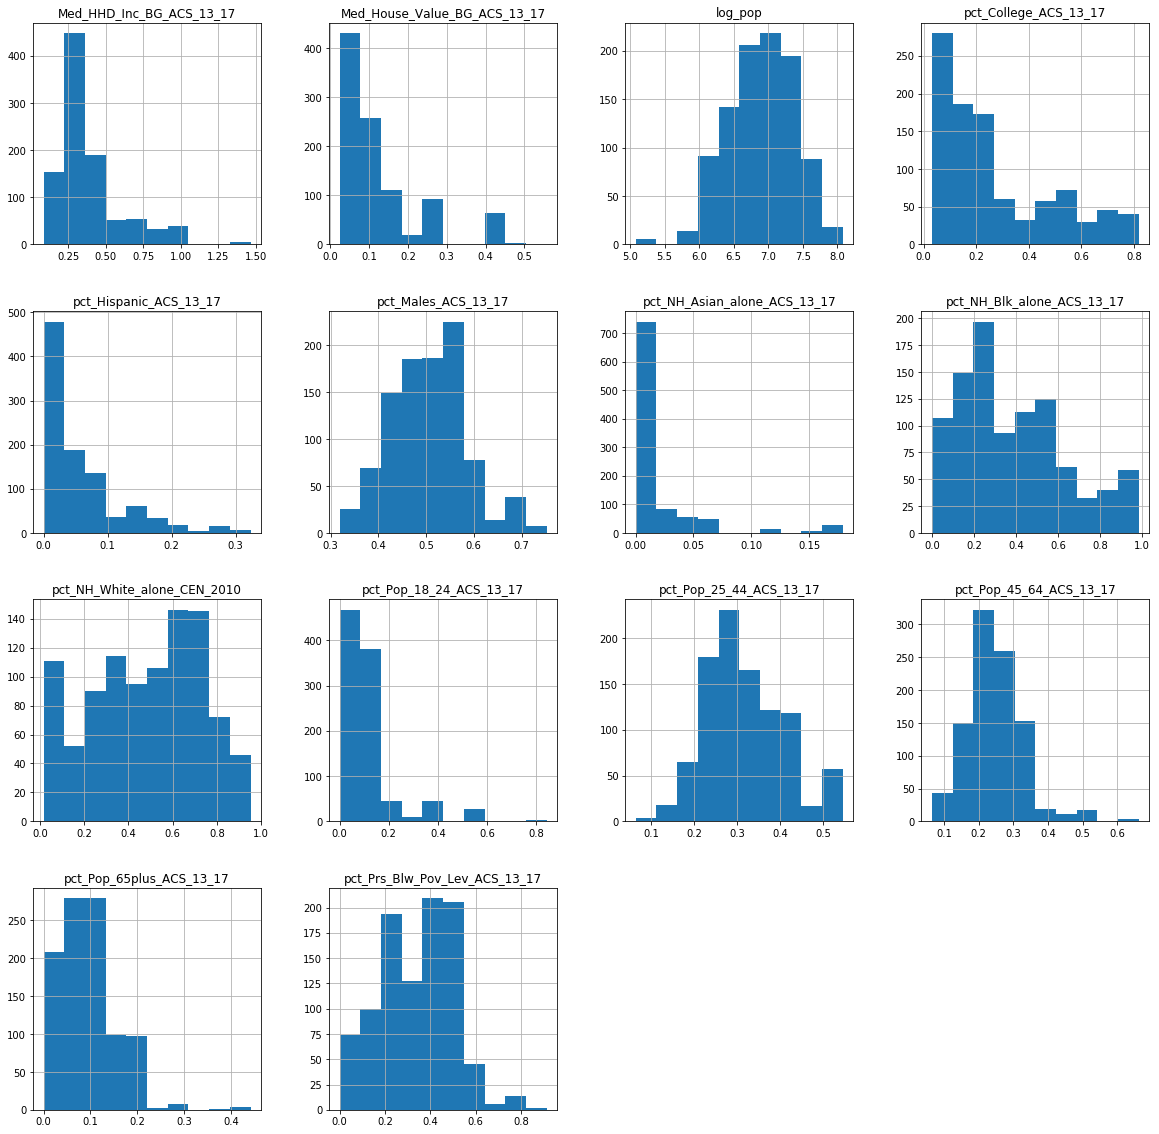

In [24]:
#get descriptive stats of predictors
X.hist(figsize=(20,20))

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
res = sm.OLS(y_train, X_train).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              ems_calls   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     211.3
Date:                Tue, 03 Mar 2020   Prob (F-statistic):          7.43e-252
Time:                        21:51:06   Log-Likelihood:                -1441.3
No. Observations:                 781   AIC:                             2911.
Df Residuals:                     767   BIC:                             2976.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
pct_Males_ACS_

In [27]:
#Check Predictions
pred = res.predict(X_test)

In [28]:
y_test.index = y_test.index.sort_values()
pred.index = pred.index.sort_values()

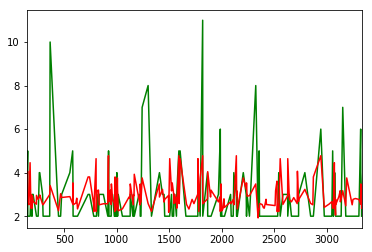

In [29]:
fig, ax = plt.subplots()
y_test.plot(style='g-', ax=ax)
pred.plot(style='r-', ax=ax)

### Tempe Sub Anaysis 

Going to split data into above and below number of calls to see if co-factors change in areas where there is a lot of drug use versus a little 

In [30]:
np.median(temp.ems_calls)

1.0

In [31]:
temp['ems_flag'] = 0 
for i in range(len(temp)):
    if temp['ems_calls'][i] >np.median(temp['ems_calls']):
        temp['ems_flag'][i] =1

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [32]:
temp.ems_flag.value_counts()

0    426
1    108
Name: ems_flag, dtype: int64

In [33]:
### partion into high and low classes 
temp_lo = temp[temp['ems_flag'] ==0]
temp_hi = temp[temp['ems_flag']==1]

In [34]:
temp_lo.shape

(426, 21)

In [35]:
temp_lo.ems_calls.value_counts()

1    426
Name: ems_calls, dtype: int64

In [36]:
temp_hi.ems_calls.shape

(108,)

In [37]:
temp_hi.ems_calls.value_counts()

2    83
3    19
4     4
5     2
Name: ems_calls, dtype: int64

#### OLS in Tempe in low use year-month tracts

In [38]:
temp_lo.dropna(inplace=True)
X, y = temp_lo, temp_lo.ems_calls
X.drop(columns=['geometry','ems_calls','year_month', 'Tot_Population_ACS_13_17', 'GIDBG', 'GEOID', 'ems_flag'], inplace=True)

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1f98d080>,
      dtype=object)

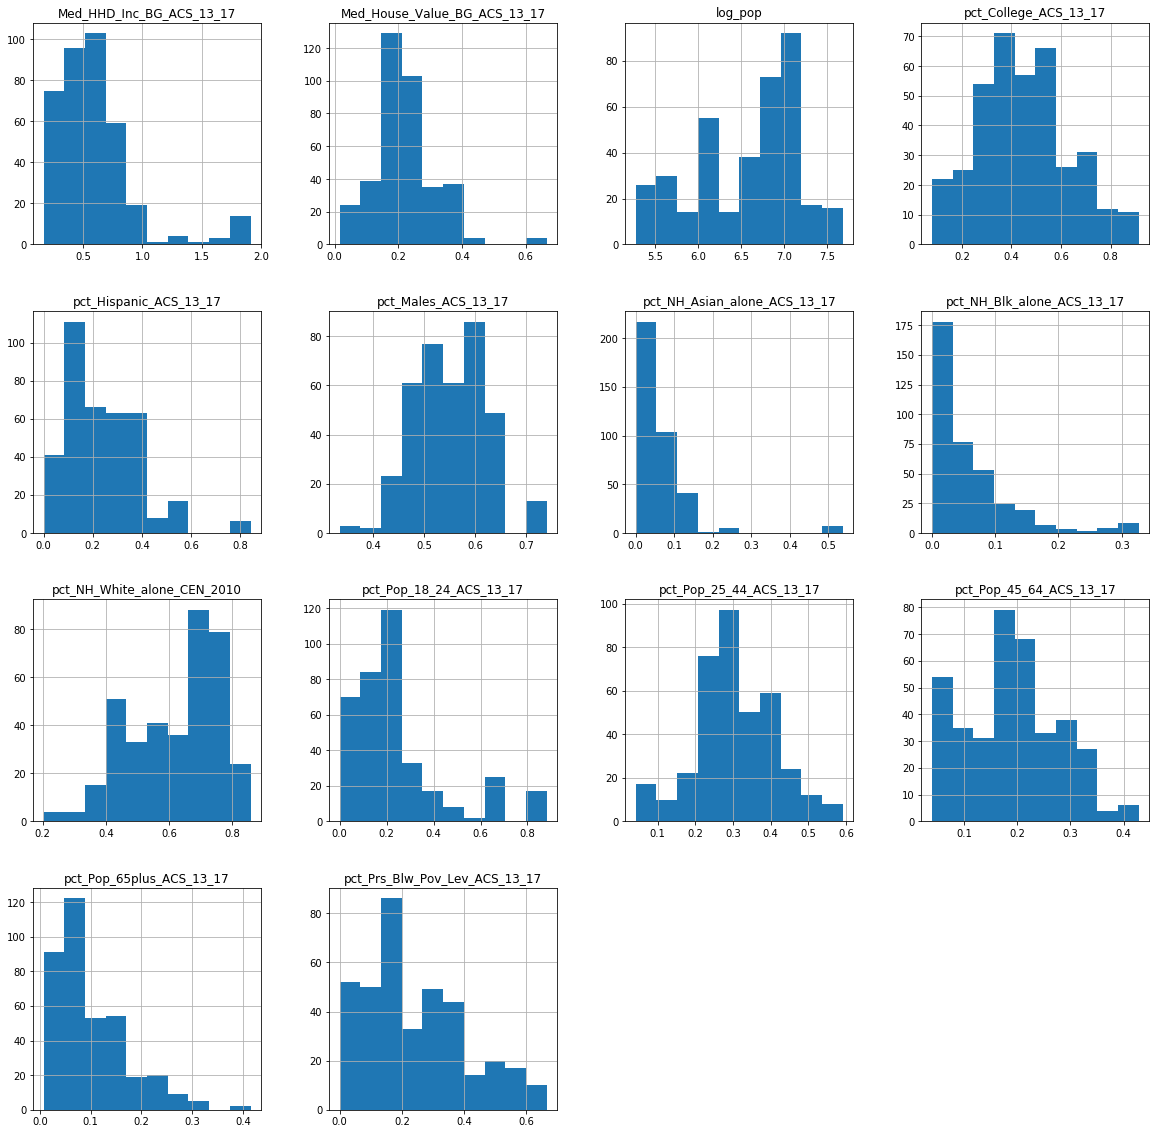

In [39]:
#get descriptive stats of predictors
X.hist(figsize=(20,20))

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
res = sm.OLS(y_train, X_train).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              ems_calls   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.295e+04
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        21:51:19   Log-Likelihood:                 542.32
No. Observations:                 300   AIC:                            -1057.
Df Residuals:                     286   BIC:                            -1005.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
pct_Males_ACS_

In [42]:
#Check Predictions
pred = res.predict(X_test)

In [43]:
y_test.index = y_test.index.sort_values()
pred.index = pred.index.sort_values()

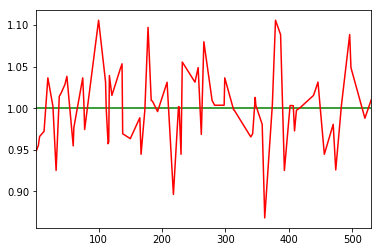

In [44]:
fig, ax = plt.subplots()
y_test.plot(style='g-', ax=ax)
pred.plot(style='r-', ax=ax)

#### OLS in Tempe in high use year-month tracts

In [45]:
temp_hi.dropna(inplace=True)
X, y = temp_hi, temp_hi.ems_calls
X.drop(columns=['geometry','ems_calls','year_month', 'Tot_Population_ACS_13_17', 'GIDBG', 'GEOID', 'ems_flag'], inplace=True)

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2041f940>,
      dtype=object)

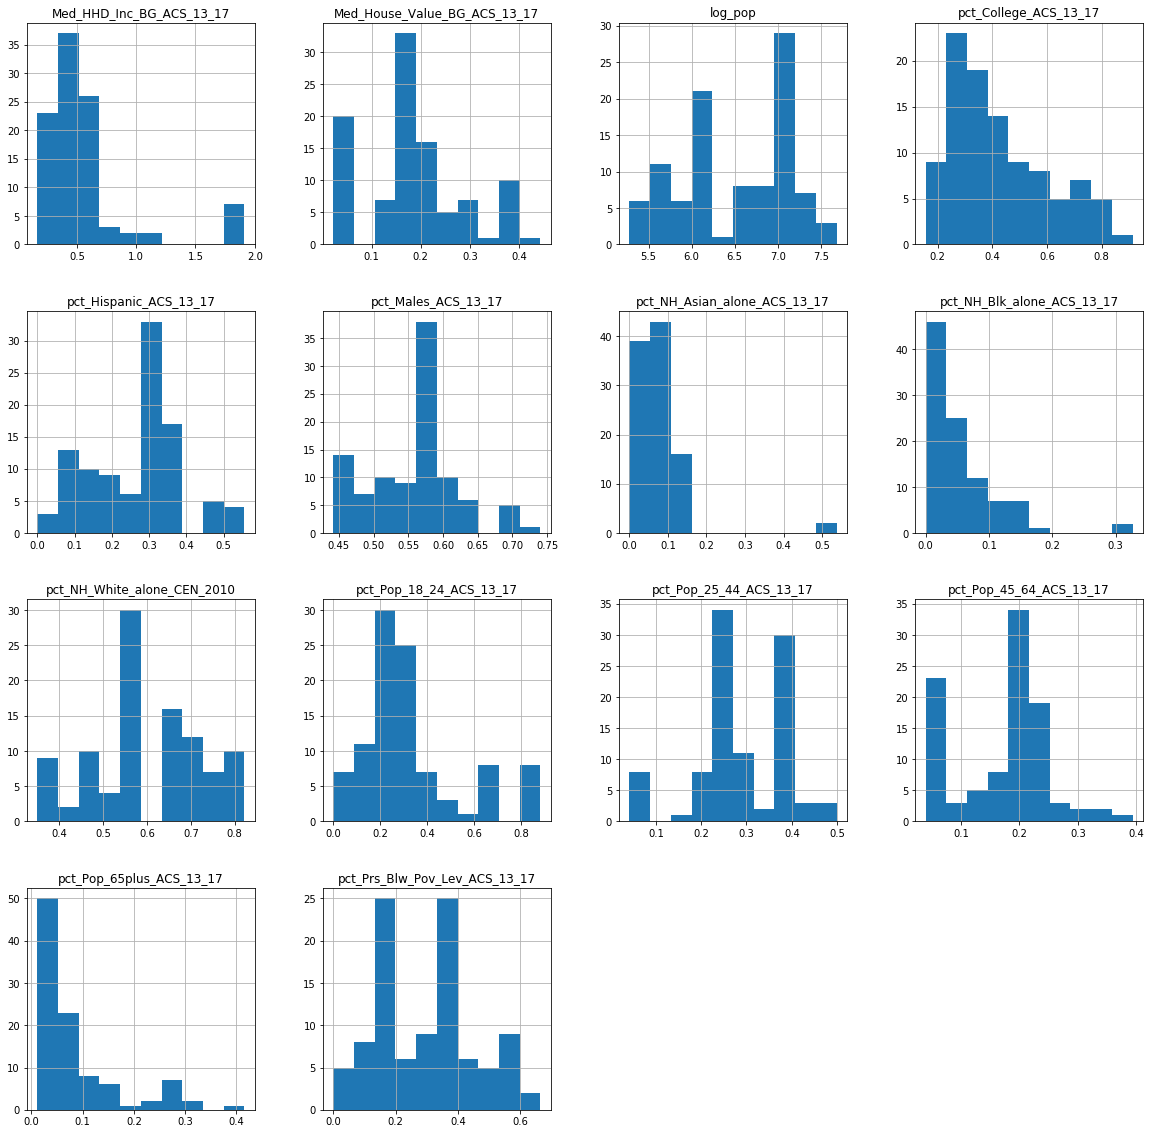

In [46]:
#get descriptive stats of predictors
X.hist(figsize=(20,20))

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
res = sm.OLS(y_train, X_train).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              ems_calls   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     81.92
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           4.48e-36
Time:                        21:51:22   Log-Likelihood:                -65.892
No. Observations:                  80   AIC:                             159.8
Df Residuals:                      66   BIC:                             193.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
pct_Males_ACS_

In [49]:
#Check Predictions
pred = res.predict(X_test)

In [50]:
y_test.index = y_test.index.sort_values()
pred.index = pred.index.sort_values()

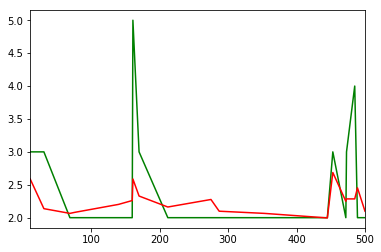

In [51]:
fig, ax = plt.subplots()
y_test.plot(style='g-', ax=ax)
pred.plot(style='r-', ax=ax)